# Personal Information
Name: **Chaoxiang Zhu**

StudentID: **15620921**

Email: [**chaoxiang.zhu@student.uva.nl**]

Submitted on: **23.03.2025**

# Data Context
**The proposed project utilizes three public datasets covering diverse types of text. The first dataset originates from a Kaggle competition on movie reviews (Rotten Tomatoes dataset). This widely used dataset in sentiment analysis contains movie reviews with detailed sentiment labels ranging from very negative to very positive. The second dataset is the Amazon product reviews dataset, which consists of millions of reviews along with star ratings serving as sentiment labels. Its coverage of many product types enables examination of how opinions vary across different products. The third dataset comes from SemEval 2016 Task 4 on Twitter sentiment analysis. This dataset includes tweets labeled as very positive, positive, very negative, negative, or neutral. Within the same source, there is more data available, if we find that the data performs poorly during formal training, we may switch to a different subset or dataset.**

Github: https://github.com/zcxfly/Task-Adaptive-Debiasing-with-SCM-for-Sentiment-Analysis

# Data Description

**Amazon Reviews**
We combined three subsets: Appliances, Fashion, and Beauty into about 10,700 samples and noticed that certain columns like style, image and vote were often empty, but our research does not require these columns. The star ratings lean heavily to 5 stars (roughly 79%), so that could cause a positivity bias. Plotting text lengths showed most reviews under 500 characters, but a handful over 2000. We also generated word clouds and extracted top n-grams: words like “rod,” “clean,” or “dryer vent” came up a lot, this helps us see how domain vocabulary might overlap with “warmth” or “competence” terms later.. Then, we compared groups by star rating (like average text length per rating) to see if 5-star texts differ from 1-star ones in length, which might matter if the model picks up length as a clue for positivity.

**Movie Comments**
We have 156k short phrases with sentiment ranging 0~4, no missing data, and about half the samples labeled as 2 (neutral-ish). We used text length histograms to confirm that most entries are super short, likely around 50 tokens or fewer. Word clouds and n-gram frequency spotlighted words like “film” and “movie,” plus bigrams with contractions like “n t.” This is helpful because certain negative expressions might revolve around “don't” or “wasn't.” Finally, grouping stats by sentiment show some small differences in text length between extremes (0 or 4) and middle (2), so we might watch if that influences any future bias in training.

**Twitter Posts**
We ended up with around 5k tweets after removing rows labeled “Not Available.” The label distribution runs from -2 to 2, but around 53% of them are labeled 1, so there's a slight positive tilt. Checking text length reveals that the majority are near 80-140 characters, typical of tweets, though a few outliers exist. Our word cloud and n-grams highlight very short, real-time words like “t co,” “may,” and “tomorrow.” Grouped comparisons by label indicate that negative tweets (-2, -1) can be a little longer.

So all these EDA steps help us see how each dataset might behave when we later integrate them with a Transformer model and use dynamic debiasing based on warmth/competence dimensions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import csv
from collections import Counter
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from IPython.display import display

### Data Loading

In [3]:

df_amazon_Appliances = pd.read_json('/content/drive/MyDrive/dataset/amazon_Appliances_5_jiadian.json', lines=True)
df_amazon_fashion = pd.read_json('/content/drive/MyDrive/dataset/AMAZON_FASHION_5_shishang.json', lines=True)
df_amazon_beauty  = pd.read_json('/content/drive/MyDrive/dataset/All_Beauty_5_meizhuang.json', lines=True)

df_amazon_Appliances['source'] = 'Appliances'
df_amazon_fashion['source'] = 'Fashion'
df_amazon_beauty['source']  = 'Beauty'

# Combine
df_amazon = pd.concat([df_amazon_Appliances, df_amazon_fashion, df_amazon_beauty],
                          ignore_index=True)


df_movie = pd.read_csv('/content/drive/MyDrive/dataset/Movie Reviews_train.tsv', sep='\t', header=0)
# Rename "Phrase" -> "review" for consistency
df_movie.rename(columns={'Phrase': 'review'}, inplace=True)


#df_twitter = pd.read_csv('dataset/train-twitter.tsv', sep='\t', header=None)
#df_twitter.columns = ['tweet_id', 'user', 'label', 'text']
df_twitter = pd.read_csv(
    '/content/drive/MyDrive/dataset/train-twitter.tsv',
    sep='\t',
    header=None,
    quoting=3,
    engine='python',
    on_bad_lines='skip'
)
df_twitter.columns = ['tweet_id', 'user', 'label', 'text']

# Convert "Not Available" to NaN
df_twitter['text'] = df_twitter['text'].replace("Not Available", np.nan)


# Drop rows where 'text' is now NaN
df_twitter.dropna(subset=['text'], inplace=True)

### Quick inspect:
We use this step to get a fast overview of each dataset's shape, columns, and missing fields. It helps us confirm data quality upfront so we don't train our sentiment/debiasing model on unexpected nulls or mislabeled columns.

In [4]:
def quick_inspect(df, dataset_name='DataFrame'):

    print(f"\n= {dataset_name} =")
    print("> First 3 rows:")
    display(df.head(3))
    print("> Shape:", df.shape)
    print("> Columns:", df.columns.tolist())
    print("> Missing values:\n", df.isnull().sum())


quick_inspect(df_amazon, 'Amazon Reviews')
quick_inspect(df_movie, 'Movie comments')
quick_inspect(df_twitter, 'Twitter posts')



= Amazon Reviews =
> First 3 rows:


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image,source
0,5,True,"08 22, 2013",A34A1UP40713F8,B00009W3I4,{'Style:': ' Dryer Vent'},James. Backus,I like this as a vent as well as something tha...,Great product,1377129600,NaN,NaN,Appliances
1,5,True,"02 8, 2016",A1AHW6I678O6F2,B00009W3PA,{'Size:': ' 6-Foot'},kevin.,good item,Five Stars,1454889600,NaN,NaN,Appliances
2,5,True,"08 5, 2015",A8R48NKTGCJDQ,B00009W3PA,{'Size:': ' 6-Foot'},CDBrannom,Fit my new LG dryer perfectly.,Five Stars,1438732800,NaN,NaN,Appliances


> Shape: (10722, 13)
> Columns: ['overall', 'verified', 'reviewTime', 'reviewerID', 'asin', 'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'vote', 'image', 'source']
> Missing values:
 overall              0
verified             0
reviewTime           0
reviewerID           0
asin                 0
style             2953
reviewerName         0
reviewText          21
summary              5
unixReviewTime       0
vote              7799
image             9690
source               0
dtype: int64

= Movie comments =
> First 3 rows:


,PhraseId,SentenceId,review,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2


> Shape: (156060, 4)
> Columns: ['PhraseId', 'SentenceId', 'review', 'Sentiment']
> Missing values:
 PhraseId      0
SentenceId    0
review        0
Sentiment     0
dtype: int64

= Twitter posts =
> First 3 rows:


,tweet_id,user,label,text
0,628949369883000832,@microsoft,-1,dear @Microsoft the newOoffice for Mac is grea...
1,628976607420645377,@microsoft,-2,@Microsoft how about you make a system that do...
4,629186282179153920,@microsoft,0,If I make a game as a #windows10 Universal App...


> Shape: (4981, 4)
> Columns: ['tweet_id', 'user', 'label', 'text']
> Missing values:
 tweet_id    0
user        0
label       0
text        0
dtype: int64


### Distribution of labels/ratings:
To checks how balanced or skewed each dataset is in terms of sentiment or star ratings. Knowing if one label dominates means we can plan to adjust sampling or weighting in our bias-mitigation approach.



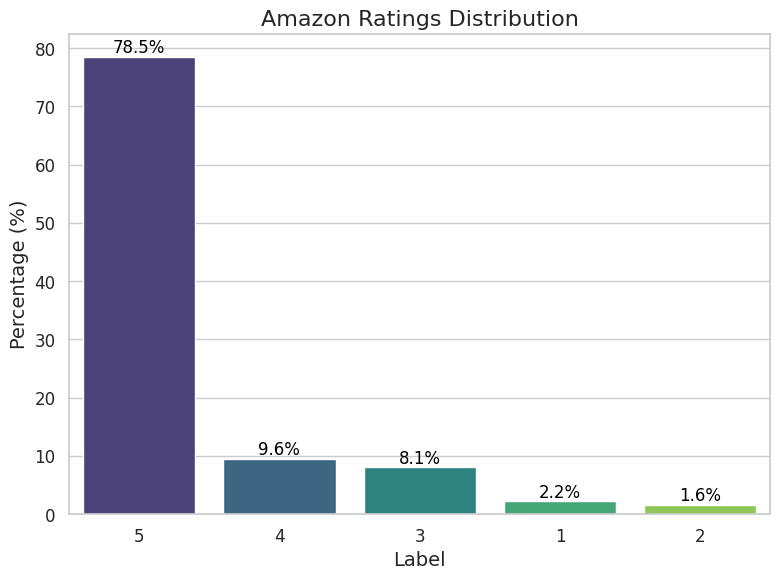

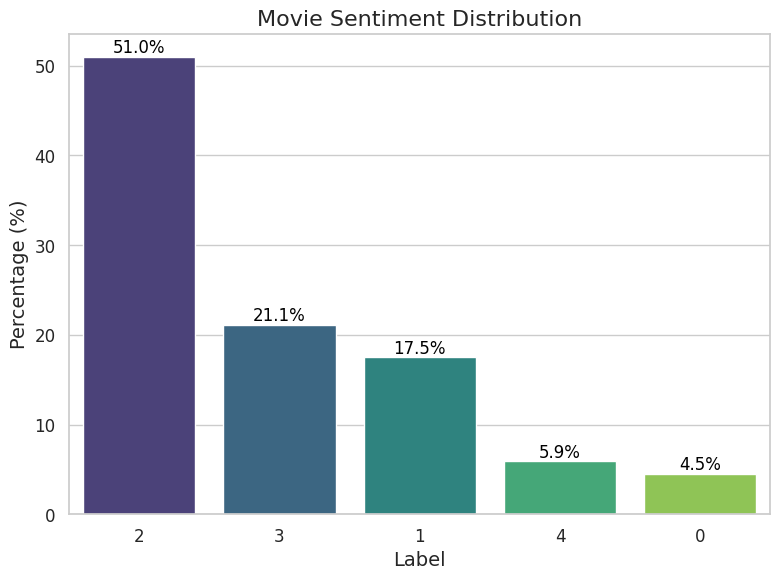

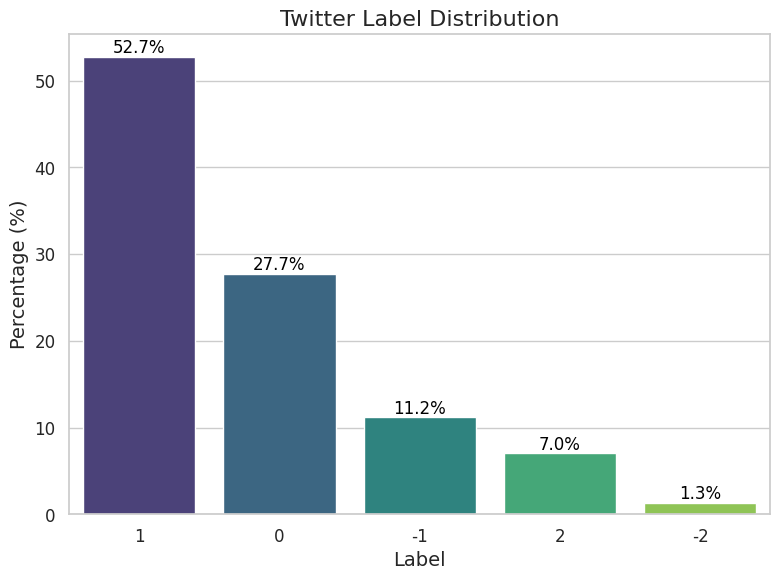

In [5]:
def plot_label_distribution(series, title='Label Distribution'):
    val_counts = series.value_counts(dropna=False)
    percentages = round(val_counts / val_counts.sum() * 100, 2)

    # print(f"\n=== {title} ===")
    # print("Counts:")
    # print(val_counts)
    # print("\nPercentages (%):")
    # print(percentages)

    df_plot = pd.DataFrame({
        'Label': val_counts.index.astype(str),
        'Count': val_counts.values,
        'Percentage': percentages.values
    })

    sns.set(style="whitegrid", font_scale=1.1)
    plt.figure(figsize=(8, 6))

    ax = sns.barplot(x="Label", y="Percentage", data=df_plot, hue="Label", dodge=False, palette="viridis")

    plt.title(title, fontsize=16)
    plt.xlabel("Label", fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=14)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%',
                    (p.get_x() + p.get_width()/2., height),
                    ha='center', va='bottom', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

# Amazon: 'overall' (1~5)
if 'overall' in df_amazon.columns:
    plot_label_distribution(df_amazon['overall'], 'Amazon Ratings Distribution')

# Movie: 'Sentiment' (0~4)
if 'Sentiment' in df_movie.columns:
    plot_label_distribution(df_movie['Sentiment'], 'Movie Sentiment Distribution')

# Twitter: 'label' (-2, -1, 0, 1, 2)
if 'label' in df_twitter.columns:
    plot_label_distribution(df_twitter['label'], 'Twitter Label Distribution')


### Text length distribution:
To plot how long reviews or tweets typically are and see if any have extreme lengths. Spotting length-based outliers early helps prevent the model from confusing text length with certain sentiments, which is important for fairness.

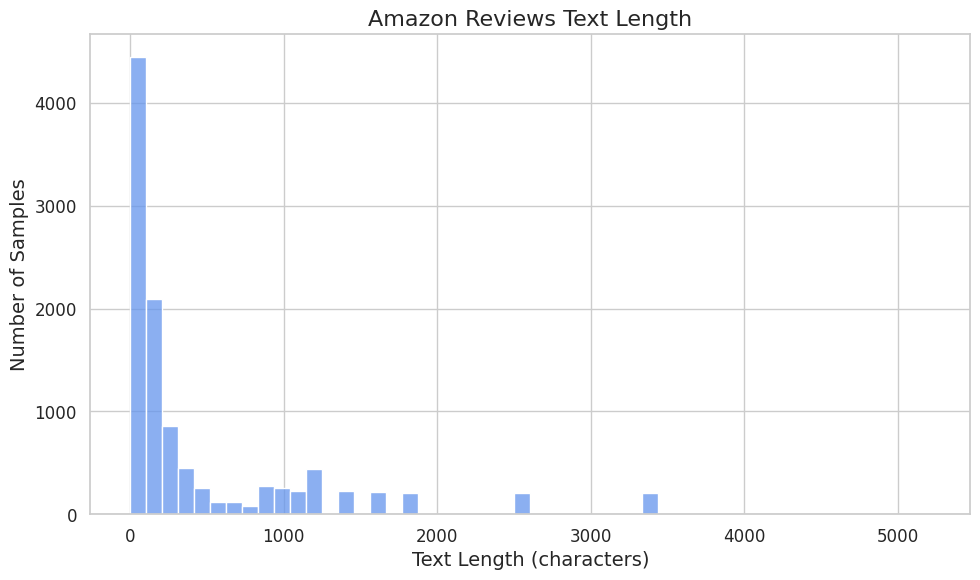

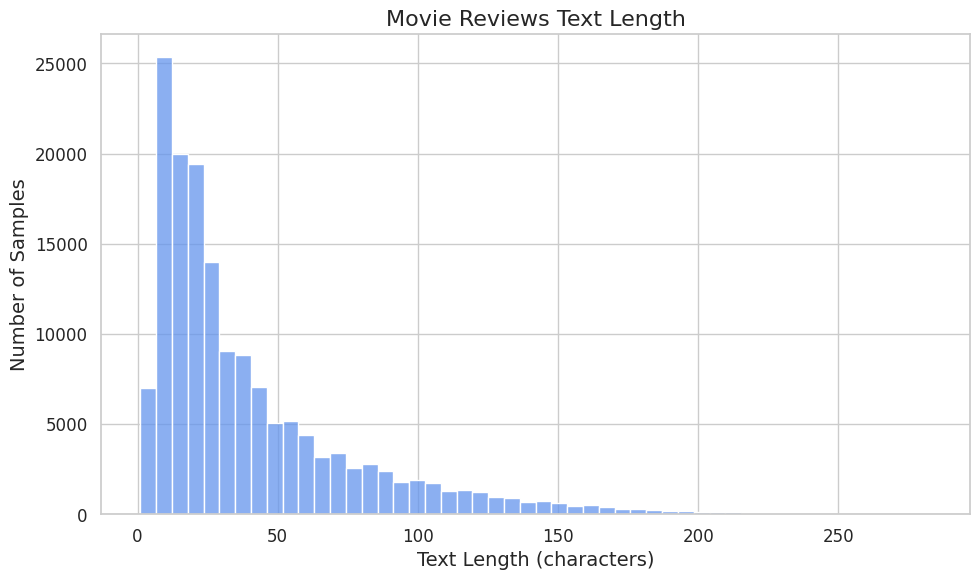

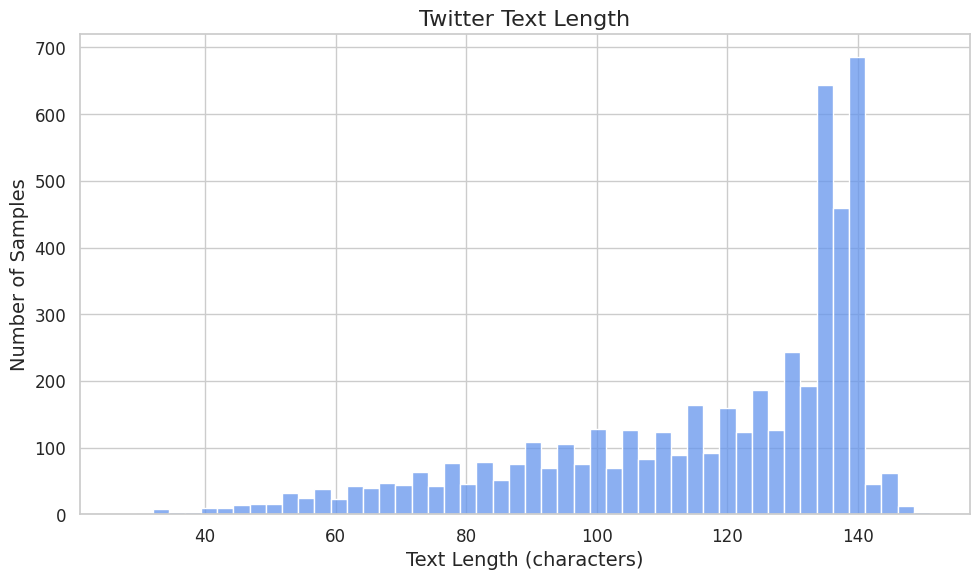

In [6]:
def plot_text_length_distribution(df, text_col, title='Text Length Distribution'):
    df['text_len'] = df[text_col].astype(str).apply(len)

    sns.set(style="whitegrid", font_scale=1.1)

    plt.figure(figsize=(10, 6))
    ax = sns.histplot(df['text_len'], bins=50, color='cornflowerblue', kde=False)
    plt.title(title, fontsize=16)
    plt.xlabel('Text Length (characters)', fontsize=14)
    plt.ylabel('Number of Samples', fontsize=14)

    plt.tight_layout()
    plt.show()



if 'reviewText' in df_amazon.columns:
    plot_text_length_distribution(df_amazon, 'reviewText', 'Amazon Reviews Text Length')


if 'review' in df_movie.columns:
    plot_text_length_distribution(df_movie, 'review', 'Movie Reviews Text Length')


if 'text' in df_twitter.columns:
    plot_text_length_distribution(df_twitter, 'text', 'Twitter Text Length')


### Word Cloud:
This give us a quick, visual sense of the most frequent words across each dataset in a single glance.. It clues us in on domain specific terms that might interact with our warmth/competence dictionaries when performing debiasing.

Top 10 words from WordCloud:
rod: 1.0000
clean: 0.8704
didn t: 0.8053
drill: 0.6875
product: 0.6193
love: 0.6078
dryer: 0.5055
dryer vent: 0.5003
used: 0.4815
time: 0.4122


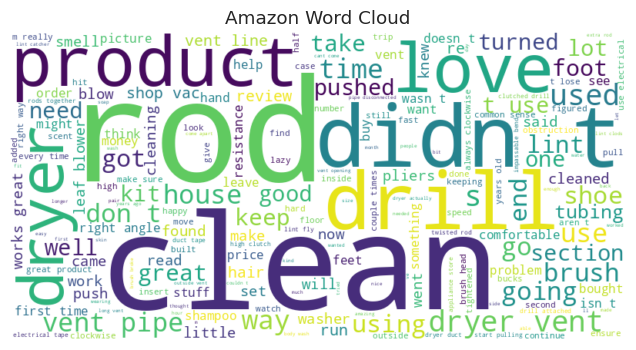

Top 10 words from WordCloud:
film: 1.0000
movie: 0.9207
n t: 0.8458
one: 0.5356
make: 0.4056
character: 0.2810
story: 0.2763
way: 0.2631
time: 0.2348
work: 0.2326


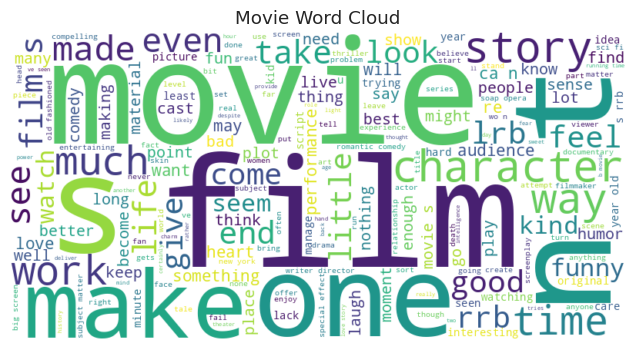

Top 10 words from WordCloud:
t co: 1.0000
may: 0.4300
tomorrow: 0.2765
will: 0.2184
https t: 0.1945
amp: 0.1535
new: 0.1442
going: 0.1359
day: 0.1333
time: 0.1094


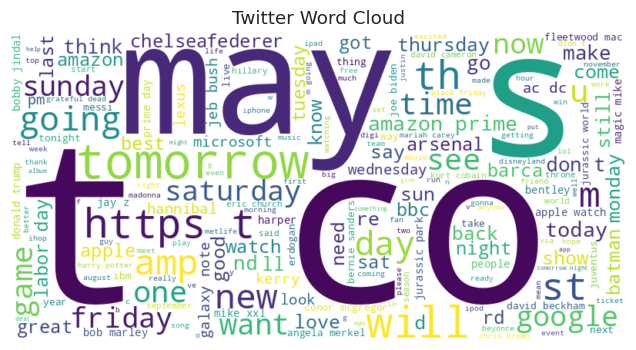

In [7]:
# Simple text cleaning: lowercase, remove non-alpha characters.
def clean_text_for_wordcloud(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]+', ' ', text)
    text = re.sub(r'https?://\S+', '', text)
    return text


def generate_wordcloud_from_df(df, text_col, title='Word Cloud'):
    # Combine all text
    all_text = " ".join(df[text_col].dropna().astype(str))
    all_text = clean_text_for_wordcloud(all_text)

    wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    # Extract the dictionary of word frequencies
    freq_dict = wc.words_
    custom_stops = {'t','s','m','n','th','st','u'}

    freq_dict = {word: freq for word, freq in freq_dict.items() if word not in custom_stops}
    # Convert to a list of tuples and sort by frequency in descending order
    top_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    print("Top 10 words from WordCloud:")
    for word, freq in top_words:
      print(f"{word}: {freq:.4f}")
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


if 'reviewText' in df_amazon.columns:
    generate_wordcloud_from_df(df_amazon, 'reviewText', 'Amazon Word Cloud')

if 'review' in df_movie.columns:
    generate_wordcloud_from_df(df_movie, 'review', 'Movie Word Cloud')

if 'text' in df_twitter.columns:
    generate_wordcloud_from_df(df_twitter, 'text', 'Twitter Word Cloud')




### N-gram Frequency Statistics:
Here we extract top two-word combos to identify common phrases. These frequently co-occurring terms might reveal strong sentiment cues we can handle carefully in our dynamic debiasing module.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


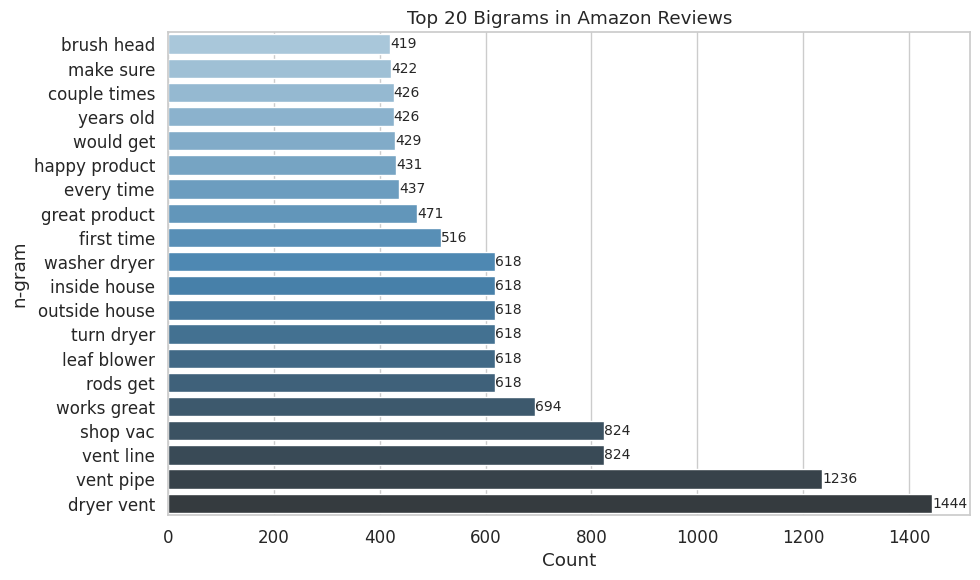

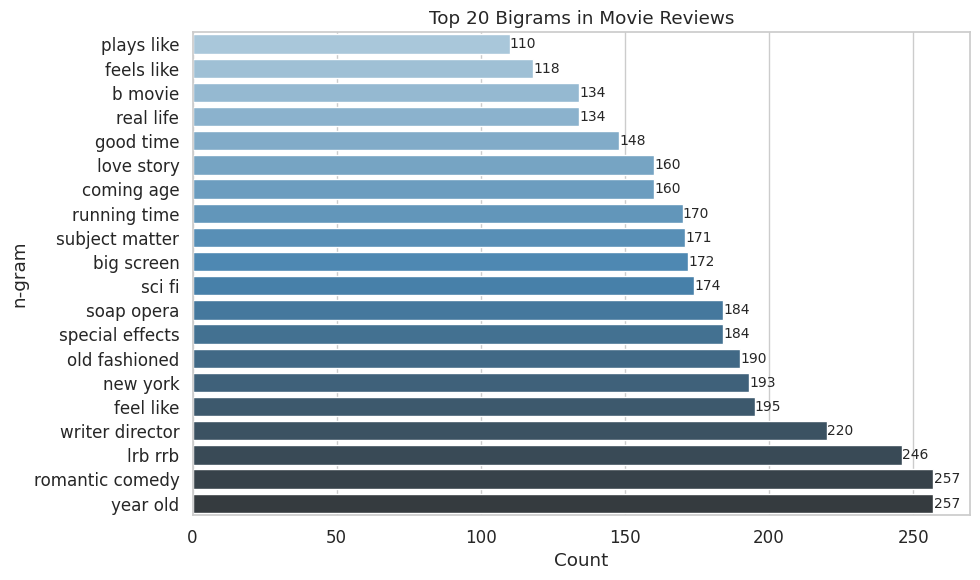

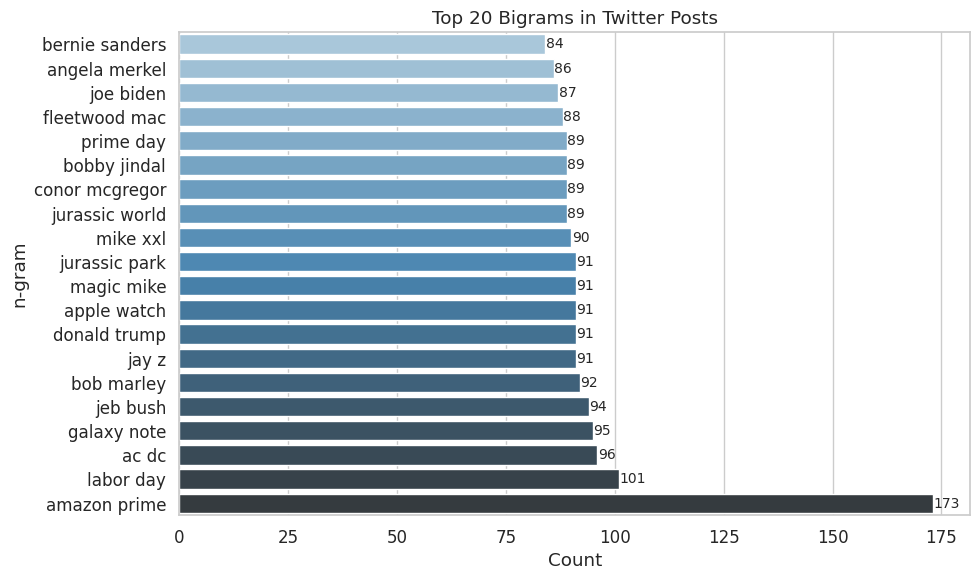

In [8]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# add more custom stopwords
custom_stops = {'t', 's', 'm', 'n', 'th', 'st'}
stop_words = stop_words.union(custom_stops)


# Clean text, tokenize and generate n-grams.
def get_ngrams(text, n=2):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    tokens = re.findall(r'[a-zA-Z]+', text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [" ".join(gram) for gram in ngrams]

# For a series of texts, compute and return the top_k most common n-grams.
def get_top_ngrams(text_series, n=2, top_k=20):

    all_ngrams = []
    for text in text_series.dropna().astype(str):
        all_ngrams.extend(get_ngrams(text, n))
    freq = Counter(all_ngrams)
    return freq.most_common(top_k)

def plot_top_ngrams(ngrams, title="Top n-grams"):

    grams, counts = zip(*ngrams)

    df_plot = pd.DataFrame({
        'n-gram': grams,
        'Count': counts
    })

    df_plot = df_plot.sort_values('Count', ascending=True)
    sns.set(style="whitegrid", font_scale=1.1)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Count", y="n-gram", data=df_plot, hue="n-gram", dodge=False, palette="Blues_d")


    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("n-gram")

    for p in ax.patches:
        width = p.get_width()
        ax.text(width + 0.1, p.get_y() + p.get_height()/2, f'{int(width)}', ha="left", va="center", fontsize=10)

    plt.tight_layout()
    plt.show()




top10_bigrams_amazon = get_top_ngrams(df_amazon['reviewText'], n=2, top_k=20)
# print("Top 10 bigrams in Amazon reviews:")
# for gram, count in top10_bigrams_amazon:
#     print(f"{gram}: {count}")
plot_top_ngrams(top10_bigrams_amazon, title="Top 20 Bigrams in Amazon Reviews")


top10_bigrams_movie = get_top_ngrams(df_movie['review'], n=2, top_k=20)
# print("Top 10 bigrams in movie reviews:")
# for gram, count in top10_bigrams_movie:
#     print(f"{gram}: {count}")
plot_top_ngrams(top10_bigrams_movie, title="Top 20 Bigrams in Movie Reviews")


top10_bigrams_twitter = get_top_ngrams(df_twitter['text'], n=2, top_k=20)
# print("Top 10 bigrams in twitter reviews:")
# for gram, count in top10_bigrams_twitter:
#     print(f"{gram}: {count}")
plot_top_ngrams(top10_bigrams_twitter, title="Top 20 Bigrams in Twitter Posts")

### Grouped Statistics Comparisons:
Here, we group data by label or rating to check differences in average text length, word counts, or other features. Such comparisons let us see if certain sentiment classes systematically have different text properties that might lead to model bias if we don't address it.

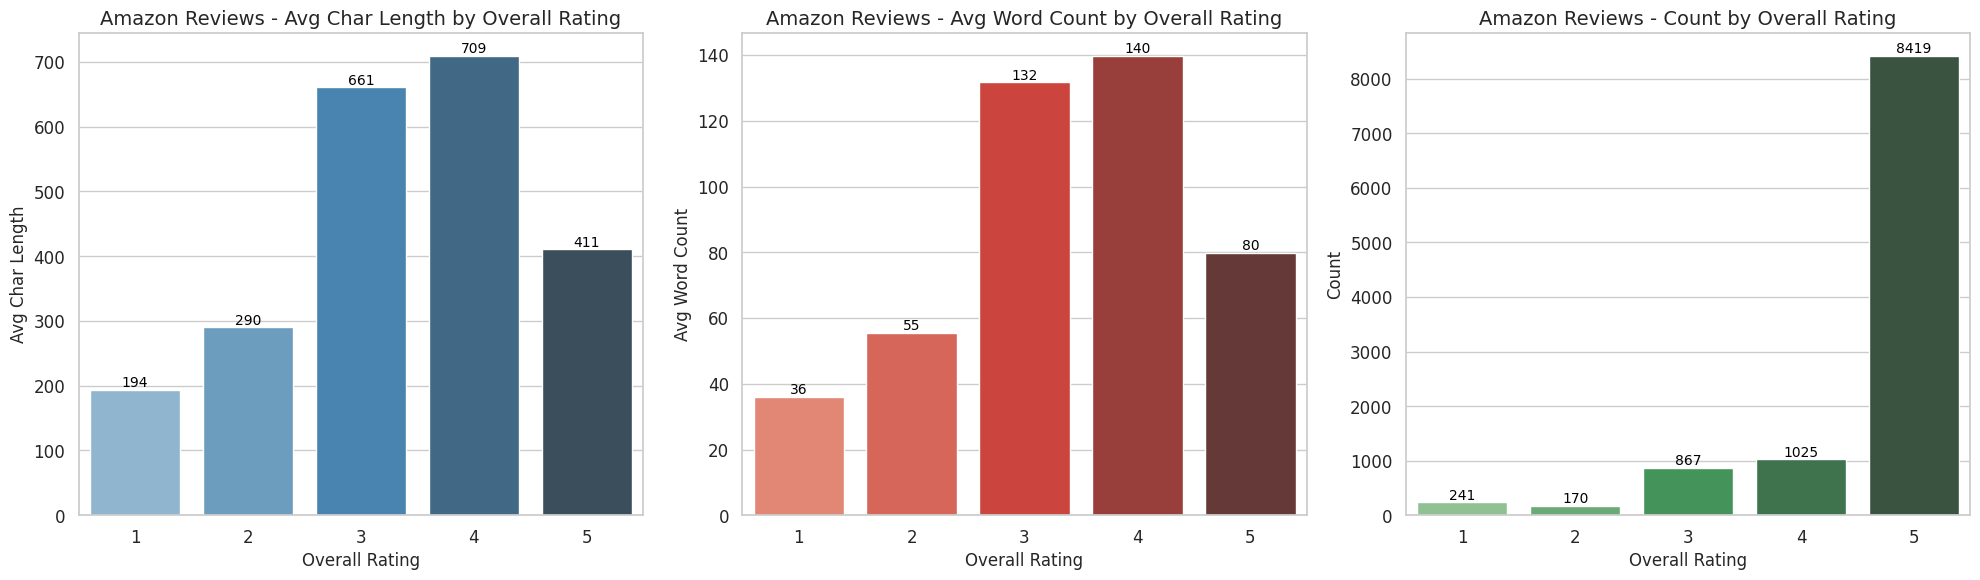

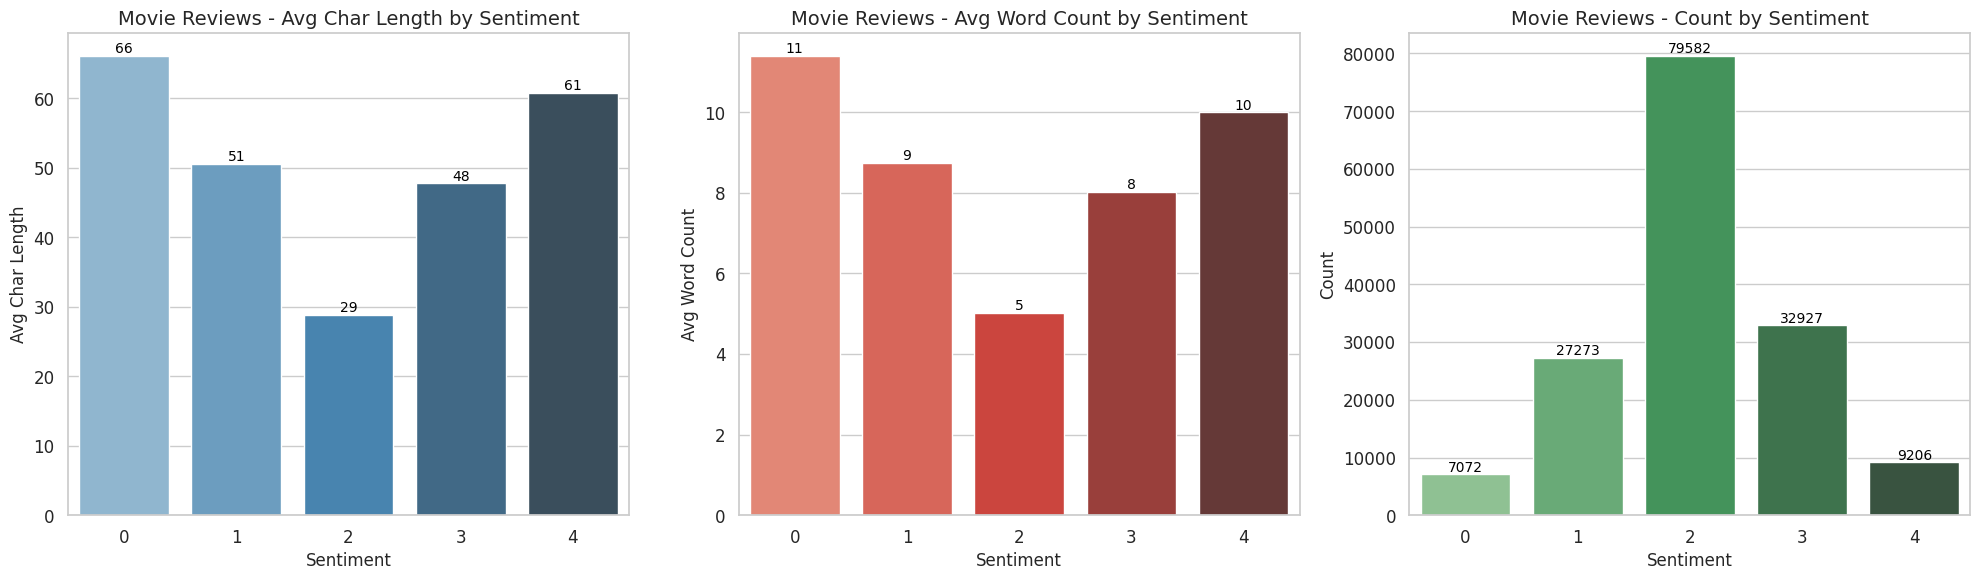

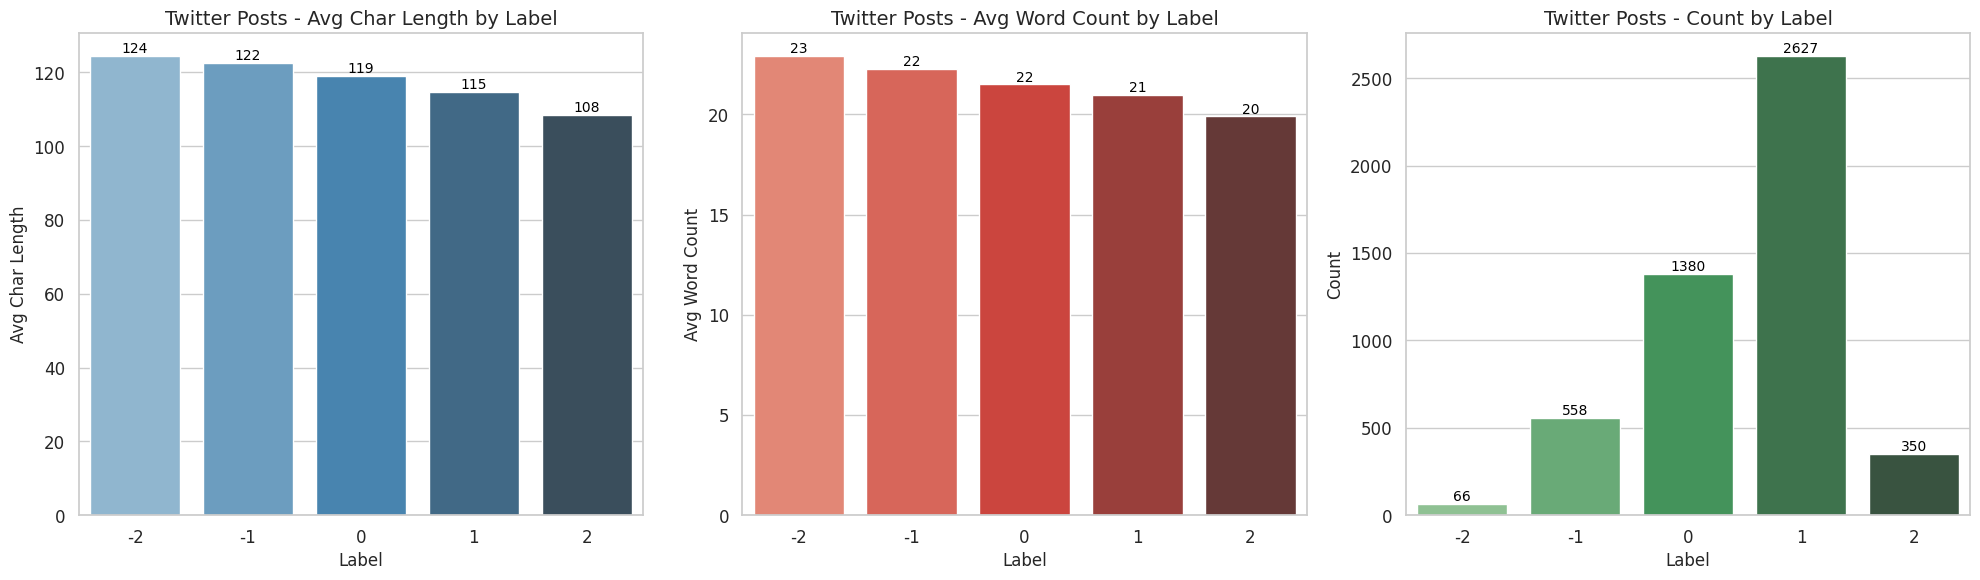

In [9]:
# Compute average text length and average word count grouped by 'overall' rating .
def compute_group_stats(df, text_col, group_col):

    df['char_length'] = df[text_col].astype(str).apply(len)
    df['word_count'] = df[text_col].astype(str).apply(lambda x: len(re.findall(r'\w+', x)))

    group_stats = df.groupby(group_col).agg(
        avg_char_length=('char_length', 'mean'),
        avg_word_count=('word_count', 'mean'),
        count=('word_count', 'count')
    )
    return group_stats

def plot_group_stats(group_stats, dataset_name, group_name):
    sns.set(style="whitegrid", font_scale=1.1)

    group_stats_sorted = group_stats.sort_index()
    groups = group_stats_sorted.index.astype(str)

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    ax0 = axes[0]
    sns.barplot(x=groups, y=group_stats_sorted['avg_char_length'],
                hue=groups, palette="Blues_d", dodge=False, ax=ax0)
    ax0.set_title(f"{dataset_name} - Avg Char Length by {group_name}", fontsize=14)
    ax0.set_xlabel(group_name, fontsize=12)
    ax0.set_ylabel("Avg Char Length", fontsize=12)
    if ax0.get_legend():
        ax0.get_legend().remove()

    ax1 = axes[1]
    sns.barplot(x=groups, y=group_stats_sorted['avg_word_count'],
                hue=groups, palette="Reds_d", dodge=False, ax=ax1)
    ax1.set_title(f"{dataset_name} - Avg Word Count by {group_name}", fontsize=14)
    ax1.set_xlabel(group_name, fontsize=12)
    ax1.set_ylabel("Avg Word Count", fontsize=12)
    if ax1.get_legend():
        ax1.get_legend().remove()

    ax2 = axes[2]
    sns.barplot(x=groups, y=group_stats_sorted['count'],
                hue=groups, palette="Greens_d", dodge=False, ax=ax2)
    ax2.set_title(f"{dataset_name} - Count by {group_name}", fontsize=14)
    ax2.set_xlabel(group_name, fontsize=12)
    ax2.set_ylabel("Count", fontsize=12)
    if ax2.get_legend():
        ax2.get_legend().remove()
    for ax in axes:
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black')

    plt.tight_layout()
    plt.show()


amazon_group_stats = compute_group_stats(df_amazon, 'reviewText', 'overall')
# print("\nAverage review statistics by Amazon overall rating:")
# print(amazon_group_stats)
plot_group_stats(amazon_group_stats, "Amazon Reviews", "Overall Rating")


movie_group_stats = compute_group_stats(df_movie, 'review', 'Sentiment')
# print("\nAverage review statistics by Movie Sentiment:")
# print(movie_group_stats)
plot_group_stats(movie_group_stats, "Movie Reviews", "Sentiment")


twitter_group_stats = compute_group_stats(df_twitter, 'text', 'label')
# print("\nAverage tweet statistics by Twitter label:")
# print(twitter_group_stats)
plot_group_stats(twitter_group_stats, "Twitter Posts", "Label")


